This python code is used to analysis the mean climatology

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
import shutil
from scipy.spatial import distance
import metpy

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import sys, os, time, warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

In [3]:
import xesmf as xe
var_name = 't2max'

vfile = sorted(glob.glob('/land1/GloSea/G6_HCST/'+var_name+'/*.nc'))
data = xr.open_dataset(vfile[0])
data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180
data = data.sortby(data.longitude).sel(latitude=slice(-60,90))

ds_out = xr.Dataset({"lat": (["lat"], data.latitude.values), "lon": (["lon"], data.longitude.values), })

In [4]:
vfile = sorted(glob.glob('/land1/MSWEP/v2.8/Past/Daily/*.nc'))
# print(vfile[4450+365*2+1])
# print(vfile[13877])
# sys.exit()

data = xr.open_mfdataset(vfile[4450+365*2+53:13847],concat_dim='time',combine='nested')['precipitation']
data = data.reindex(lat=data.lat[::-1]).sel(lat=slice(-60,90))

regridder = xe.Regridder(data, ds_out, "bilinear")
pr_rgd = regridder(data)
del data

In [5]:
vfile = sorted(glob.glob('/land1/CPC/tmax/tmax.*.nc'))
data = xr.open_mfdataset(vfile[14:38],concat_dim='time',combine='nested')['tmax']

data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1]).sel(lat=slice(-60,90))

# ds_out = xr.Dataset({"lat": (["lat"], data.lat.values), "lon": (["lon"], data.lon.values), })
regridder = xe.Regridder(data, ds_out, "bilinear")
tmax_rgd = regridder(data)
del data

In [6]:
vfile = sorted(glob.glob('/land1/CPC/tmin/tmin.*.nc'))
data = xr.open_mfdataset(vfile[14:38],concat_dim='time',combine='nested')['tmin']

data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
data = data.sortby(data.lon)
data = data.reindex(lat=data.lat[::-1]).sel(lat=slice(-60,90))

# ds_out = xr.Dataset({"lat": (["lat"], data.lat.values), "lon": (["lon"], data.lon.values), })
regridder = xe.Regridder(data, ds_out, "bilinear")
tmin_rgd = regridder(data)
del data

In [7]:
tmean_rgd = ( tmin_rgd + tmax_rgd ) / 2.
tmean_rgd

<xarray.DataArray (time: 8766, lat: 270, lon: 432)>
dask.array<truediv, shape=(8766, 270, 432), dtype=float32, chunksize=(366, 270, 432), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2016-12-31
  * lat      (lat) float32 -59.72 -59.17 -58.61 -58.06 ... 88.61 89.17 89.72
  * lon      (lon) float32 -179.6 -178.8 -177.9 -177.1 ... 177.9 178.8 179.6

In [8]:
var_name1 = 't2m'
var_name2 = 't2min'
var_name3 = 't2max'
var_name4 = 'precip'
var_name = 'temp'
dir='/land1/GloSea/G5_HCST/'
nlead = 2

ens_g5 = 3
syear_g5 = 1993
eyear_g5 = 2016
season_g5 = "MJJA"

if season_g5 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g5 == "DJF":
    mons = [1,2,12]
elif season_g5 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g5 == "SON":
    mons = [x for x in range(9,12)]
elif season_g5 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g5 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g5,eyear_g5+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        


tmean_g5 = xr.DataArray(data = np.empty([len(years),len(init_dates),ens_g5,nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                        dims=["years","init_dates","ensembles","leads","lat","lon"],
                        coords = dict(years=(["years"], years),
                                      init_dates=(["init_dates"], init_dates),
                                      ensembles=(["ensembles"], [x for x in range(ens_g5)]),
                                      leads=(["leads"], [x for x in range(nlead)]),
                                      lat=(["lat"], ds_out.lat.values),
                                      lon=(["lon"], ds_out.lon.values),
                                     )
                       )
tmax_g5 = tmean_g5.copy(deep=True)
tmin_g5 = tmean_g5.copy(deep=True)
pr_g5 = tmean_g5.copy(deep=True)

tmean_obs = xr.DataArray(data = np.empty([len(years),len(init_dates),nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan,
                         dims=["years","init_dates","leads","lat","lon"],
                         coords = dict(years=(["years"], years),
                                       init_dates=(["init_dates"], init_dates),
                                       leads=(["leads"], [x for x in range(nlead)]),
                                       lat=(["lat"], ds_out.lat.values),
                                       lon=(["lon"], ds_out.lon.values),
                                      )
                        )
tmax_obs = tmean_obs.copy(deep=True)
tmin_obs = tmean_obs.copy(deep=True)
pr_obs = tmean_obs.copy(deep=True)

for y,yr in enumerate(years):
    print(yr)
    for i,id in enumerate(init_dates):
        # print(yr,id)
        # Tmean
        vfile = sorted(glob.glob(dir+var_name1+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name].isel(ht=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        data2 = data1 -273.15
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        tmean_g5[y,i,:len(data2.ens),0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmean_g5[y,i,:len(data2.ens),1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        tmean_obs[y,i,0,:,:] = tmean_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmean_obs[y,i,1,:,:] = tmean_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data2
        del init_date
        del time_day
        
        # Tmin
        vfile = sorted(glob.glob(dir+var_name2+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name].isel(ht=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        data2 = data1.resample(time='1D',base=0,keep_attrs=True).min(keep_attrs=True) -273.15
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        tmin_g5[y,i,:len(data2.ens),0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmin_g5[y,i,:len(data2.ens),1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        tmin_obs[y,i,0,:,:] = tmin_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmin_obs[y,i,1,:,:] = tmin_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data2
        del init_date
        del time_day
        
        # Tmax
        vfile = sorted(glob.glob(dir+var_name3+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name].isel(ht=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        data2 = data1.resample(time='1D',base=0,keep_attrs=True).max(keep_attrs=True) -273.15
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        tmax_g5[y,i,:len(data2.ens),0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmax_g5[y,i,:len(data2.ens),1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        tmax_obs[y,i,0,:,:] = tmax_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmax_obs[y,i,1,:,:] = tmax_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data2
        del init_date
        del time_day
        # sys.exit()

        # Precipitation
        vfile = sorted(glob.glob(dir+var_name4+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name4].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        data2 = data1.resample(time='1D',base=0,keep_attrs=True).mean(keep_attrs=True) * 3600.
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        pr_g5[y,i,:,0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        pr_g5[y,i,:,1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        pr_obs[y,i,0,:,:] = pr_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        pr_obs[y,i,1,:,:] = pr_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data2
        del init_date
        del time_day
        
del tmax_rgd, tmean_rgd, tmin_rgd, pr_rgd

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [9]:
var_name1 = 't2m'
var_name2 = 't2min'
var_name3 = 't2max'
var_name4 = 'precip'
var_name = 'temp'
dir='/land1/GloSea/G6_HCST/'
nlead = 2

ens_g6 = 7
syear_g6 = 1993
eyear_g6 = 2016
season_g6 = "MJJA"

if season_g6 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g6 == "DJF":
    mons = [1,2,12]
elif season_g6 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g6 == "SON":
    mons = [x for x in range(9,12)]
elif season_g6 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g6 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g6,eyear_g6+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        


tmean_g6 = xr.DataArray(data = np.empty([len(years),len(init_dates),ens_g6,nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                        dims=["years","init_dates","ensembles","leads","lat","lon"],
                        coords = dict(years=(["years"], years),
                                      init_dates=(["init_dates"], init_dates),
                                      ensembles=(["ensembles"], [x for x in range(ens_g6)]),
                                      leads=(["leads"], [x for x in range(nlead)]),
                                      lat=(["lat"], ds_out.lat.values),
                                      lon=(["lon"], ds_out.lon.values),
                                     )
                       )
tmax_g6 = tmean_g6.copy(deep=True)
tmin_g6 = tmean_g6.copy(deep=True)
pr_g6 = tmean_g6.copy(deep=True)

for y,yr in enumerate(years):
    print(yr)
    for i,id in enumerate(init_dates):
        # print(yr,id)
        # Tmean
        vfile = sorted(glob.glob(dir+var_name1+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name].isel(ht=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        data2 = data1 -273.15
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        tmean_g6[y,i,:len(data2.ens),0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmean_g6[y,i,:len(data2.ens),1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
     
        del data2
        del init_date
        del time_day
        
        # Tmin
        vfile = sorted(glob.glob(dir+var_name2+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name].isel(ht=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        data2 = data1.resample(time='1D',base=0,keep_attrs=True).min(keep_attrs=True) -273.15
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        tmin_g6[y,i,:len(data2.ens),0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmin_g6[y,i,:len(data2.ens),1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
    
        del data2
        del init_date
        del time_day
        
        # Tmax
        vfile = sorted(glob.glob(dir+var_name3+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name].isel(ht=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        data2 = data1.resample(time='1D',base=0,keep_attrs=True).max(keep_attrs=True) -273.15
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        tmax_g6[y,i,:len(data2.ens),0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        tmax_g6[y,i,:len(data2.ens),1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
  
        del data2
        del init_date
        del time_day

        # Precipitation
        vfile = sorted(glob.glob(dir+var_name4+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name4].isel(surface=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'}).sel(lat=slice(-60,90))
        data2 = data1.resample(time='1D',base=0,keep_attrs=True).mean(keep_attrs=True) * 3600.
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        pr_g6[y,i,:,0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        pr_g6[y,i,:,1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data2
        del init_date
        del time_day        
        # sys.exit()

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [10]:
def cal_rmse(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    RMSE : xarray
        calculated RMSE
    """
    diff = ( b - a ) ** 2
    return ( diff.mean(dim) ) ** 0.5

def cal_bias(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    RMSE : xarray
        calculated RMSE
    """
    diff = b - a
    return diff.mean(dim)

def area_avg_weight(a, lon_str, lat_str):
    weights = np.cos(np.deg2rad(a.lat))
    weights.name = "weights"
    a_weighted = a.weighted(weights)
    weighted_mean = a_weighted.mean(("lon", "lat"))
    return weighted_mean.values.item()

country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m',
    facecolor='none')

In [12]:
corr_tmax_g5 =  xr.corr(tmax_obs, tmax_g5.mean(dim='ensembles'), 'years')
corr_tmax_g6 =  xr.corr(tmax_obs, tmax_g6.mean(dim='ensembles'), 'years')

rmse_tmax_g5 = cal_rmse(tmax_obs, tmax_g5.mean(dim='ensembles'), 'years')
rmse_tmax_g6 = cal_rmse(tmax_obs, tmax_g6.mean(dim='ensembles'), 'years')

bias_tmax_g5 = cal_bias(tmax_obs, tmax_g5.mean(dim='ensembles'), 'years')
bias_tmax_g6 = cal_bias(tmax_obs, tmax_g6.mean(dim='ensembles'), 'years')

In [13]:
corr_tmin_g5 =  xr.corr(tmin_obs, tmin_g5.mean(dim='ensembles'), 'years')
corr_tmin_g6 =  xr.corr(tmin_obs, tmin_g6.mean(dim='ensembles'), 'years')

rmse_tmin_g5 = cal_rmse(tmin_obs, tmin_g5.mean(dim='ensembles'), 'years')
rmse_tmin_g6 = cal_rmse(tmin_obs, tmin_g6.mean(dim='ensembles'), 'years')

bias_tmin_g5 = cal_bias(tmin_obs, tmin_g5.mean(dim='ensembles'), 'years')
bias_tmin_g6 = cal_bias(tmin_obs, tmin_g6.mean(dim='ensembles'), 'years')

In [14]:
corr_tmean_g5 =  xr.corr(tmean_obs, tmean_g5.mean(dim='ensembles'), 'years')
corr_tmean_g6 =  xr.corr(tmean_obs, tmean_g6.mean(dim='ensembles'), 'years')

rmse_tmean_g5 = cal_rmse(tmean_obs, tmean_g5.mean(dim='ensembles'), 'years')
rmse_tmean_g6 = cal_rmse(tmean_obs, tmean_g6.mean(dim='ensembles'), 'years')

bias_tmean_g5 = cal_bias(tmean_obs, tmean_g5.mean(dim='ensembles'), 'years')
bias_tmean_g6 = cal_bias(tmean_obs, tmean_g6.mean(dim='ensembles'), 'years')

In [15]:
corr_pr_g5 =  xr.corr(pr_obs, pr_g5.mean(dim='ensembles'), 'years')
corr_pr_g6 =  xr.corr(pr_obs, pr_g6.mean(dim='ensembles'), 'years')

rmse_pr_g5 = cal_rmse(pr_obs, pr_g5.mean(dim='ensembles'), 'years')
rmse_pr_g6 = cal_rmse(pr_obs, pr_g6.mean(dim='ensembles'), 'years')

bias_pr_g5 = cal_bias(pr_obs, pr_g5.mean(dim='ensembles'), 'years')
bias_pr_g6 = cal_bias(pr_obs, pr_g6.mean(dim='ensembles'), 'years')

In [16]:
bias_map = xr.DataArray(data = np.empty([3,3,nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                        dims=["maps","vars","leads","lat","lon"],
                        coords = dict(vars=(["vars"], [x for x in range(3)]),
                                      maps=(["maps"], [x for x in range(3)]),
                                      leads=(["leads"], [x for x in range(nlead)]),
                                      lat=(["lat"], ds_out.lat.values),
                                      lon=(["lon"], ds_out.lon.values),
                                     )
                       )

rmse_map = bias_map.copy(deep=True)
corr_map = bias_map.copy(deep=True)

bias_sig_map = bias_map.copy(deep=True)
rmse_sig_map = bias_map.copy(deep=True)

bias_map[0,0,:,:,:] = bias_tmean_g5.mean(dim='init_dates')
bias_map[1,0,:,:,:] = bias_tmean_g6.mean(dim='init_dates')
bias_map[2,0,:,:,:] = bias_tmean_g6.mean(dim='init_dates') - bias_tmean_g5.mean(dim='init_dates')
bias_map[0,1,:,:,:] = bias_tmax_g5.mean(dim='init_dates')
bias_map[1,1,:,:,:] = bias_tmax_g6.mean(dim='init_dates')
bias_map[2,1,:,:,:] = bias_tmax_g6.mean(dim='init_dates') - bias_tmax_g5.mean(dim='init_dates')
bias_map[0,2,:,:,:] = bias_tmin_g5.mean(dim='init_dates')
bias_map[1,2,:,:,:] = bias_tmin_g6.mean(dim='init_dates')
bias_map[2,2,:,:,:] = bias_tmin_g6.mean(dim='init_dates') - bias_tmin_g5.mean(dim='init_dates')

rmse_map[0,0,:,:,:] = rmse_tmean_g5.mean(dim='init_dates')
rmse_map[1,0,:,:,:] = rmse_tmean_g6.mean(dim='init_dates')
rmse_map[2,0,:,:,:] = rmse_tmean_g6.mean(dim='init_dates') - rmse_tmean_g5.mean(dim='init_dates')
rmse_map[0,1,:,:,:] = rmse_tmax_g5.mean(dim='init_dates')
rmse_map[1,1,:,:,:] = rmse_tmax_g6.mean(dim='init_dates')
rmse_map[2,1,:,:,:] = rmse_tmax_g6.mean(dim='init_dates') - rmse_tmax_g5.mean(dim='init_dates')
rmse_map[0,2,:,:,:] = rmse_tmin_g5.mean(dim='init_dates')
rmse_map[1,2,:,:,:] = rmse_tmin_g6.mean(dim='init_dates')
rmse_map[2,2,:,:,:] = rmse_tmin_g6.mean(dim='init_dates') - rmse_tmin_g5.mean(dim='init_dates')

corr_map[0,0,:,:,:] = corr_tmean_g5.mean(dim='init_dates')
corr_map[1,0,:,:,:] = corr_tmean_g6.mean(dim='init_dates')
corr_map[2,0,:,:,:] = corr_tmean_g6.mean(dim='init_dates') - corr_tmean_g5.mean(dim='init_dates')
corr_map[0,1,:,:,:] = corr_tmax_g5.mean(dim='init_dates')
corr_map[1,1,:,:,:] = corr_tmax_g6.mean(dim='init_dates')
corr_map[2,1,:,:,:] = corr_tmax_g6.mean(dim='init_dates') - corr_tmax_g5.mean(dim='init_dates')
corr_map[0,2,:,:,:] = corr_tmin_g5.mean(dim='init_dates')
corr_map[1,2,:,:,:] = corr_tmin_g6.mean(dim='init_dates')
corr_map[2,2,:,:,:] = corr_tmin_g6.mean(dim='init_dates') - corr_tmin_g5.mean(dim='init_dates')

bias_sig_map[0,0,:,:,:] = stats.ttest_ind( tmean_obs.stack(samp=("years", "init_dates")),             tmean_g5.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue
bias_sig_map[1,0,:,:,:] = stats.ttest_ind( tmean_obs.stack(samp=("years", "init_dates")),             tmean_g6.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue
bias_sig_map[2,0,:,:,:] = stats.ttest_ind( tmean_g6.stack(samp=("years", "init_dates", "ensembles")), tmean_g5.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue

bias_sig_map[0,1,:,:,:] = stats.ttest_ind( tmax_obs.stack(samp=("years", "init_dates")),             tmax_g5.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue
bias_sig_map[1,1,:,:,:] = stats.ttest_ind( tmax_obs.stack(samp=("years", "init_dates")),             tmax_g6.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue
bias_sig_map[2,1,:,:,:] = stats.ttest_ind( tmax_g6.stack(samp=("years", "init_dates", "ensembles")), tmax_g5.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue

bias_sig_map[0,2,:,:,:] = stats.ttest_ind( tmin_obs.stack(samp=("years", "init_dates")),             tmin_g5.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue
bias_sig_map[1,2,:,:,:] = stats.ttest_ind( tmin_obs.stack(samp=("years", "init_dates")),             tmin_g6.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue
bias_sig_map[2,2,:,:,:] = stats.ttest_ind( tmin_g6.stack(samp=("years", "init_dates", "ensembles")), tmin_g5.stack(samp=("years", "init_dates", "ensembles")), axis=3, equal_var=False ).pvalue


rmse_sig_map[2,0,:,:,:] = stats.ttest_ind( rmse_tmean_g5, rmse_tmean_g6, axis=0, equal_var=False ).pvalue
rmse_sig_map[2,1,:,:,:] = stats.ttest_ind( rmse_tmax_g5,  rmse_tmax_g6, axis=0, equal_var=False ).pvalue
rmse_sig_map[2,2,:,:,:] = stats.ttest_ind( rmse_tmin_g5,  rmse_tmin_g6, axis=0, equal_var=False ).pvalue

In [17]:
corr_tmax_g52 =  xr.corr(tmax_obs.mean(dim='leads'), tmax_g5.mean(dim=('ensembles','leads')), 'years')
corr_tmax_g62 =  xr.corr(tmax_obs.mean(dim='leads'), tmax_g6.mean(dim=('ensembles','leads')), 'years')
rmse_tmax_g52 = cal_rmse(tmax_obs.mean(dim='leads'), tmax_g5.mean(dim=('ensembles','leads')), 'years')
rmse_tmax_g62 = cal_rmse(tmax_obs.mean(dim='leads'), tmax_g6.mean(dim=('ensembles','leads')), 'years')
bias_tmax_g52 = cal_bias(tmax_obs.mean(dim='leads'), tmax_g5.mean(dim=('ensembles','leads')), 'years')
bias_tmax_g62 = cal_bias(tmax_obs.mean(dim='leads'), tmax_g6.mean(dim=('ensembles','leads')), 'years')

corr_tmin_g52 =  xr.corr(tmin_obs.mean(dim='leads'), tmin_g5.mean(dim=('ensembles','leads')), 'years')
corr_tmin_g62 =  xr.corr(tmin_obs.mean(dim='leads'), tmin_g6.mean(dim=('ensembles','leads')), 'years')
rmse_tmin_g52 = cal_rmse(tmin_obs.mean(dim='leads'), tmin_g5.mean(dim=('ensembles','leads')), 'years')
rmse_tmin_g62 = cal_rmse(tmin_obs.mean(dim='leads'), tmin_g6.mean(dim=('ensembles','leads')), 'years')
bias_tmin_g52 = cal_bias(tmin_obs.mean(dim='leads'), tmin_g5.mean(dim=('ensembles','leads')), 'years')
bias_tmin_g62 = cal_bias(tmin_obs.mean(dim='leads'), tmin_g6.mean(dim=('ensembles','leads')), 'years')

corr_tmean_g52 =  xr.corr(tmean_obs.mean(dim='leads'), tmean_g5.mean(dim=('ensembles','leads')), 'years')
corr_tmean_g62 =  xr.corr(tmean_obs.mean(dim='leads'), tmean_g6.mean(dim=('ensembles','leads')), 'years')
rmse_tmean_g52 = cal_rmse(tmean_obs.mean(dim='leads'), tmean_g5.mean(dim=('ensembles','leads')), 'years')
rmse_tmean_g62 = cal_rmse(tmean_obs.mean(dim='leads'), tmean_g6.mean(dim=('ensembles','leads')), 'years')
bias_tmean_g52 = cal_bias(tmean_obs.mean(dim='leads'), tmean_g5.mean(dim=('ensembles','leads')), 'years')
bias_tmean_g62 = cal_bias(tmean_obs.mean(dim='leads'), tmean_g6.mean(dim=('ensembles','leads')), 'years')

corr_pr_g52 =  xr.corr(pr_obs.mean(dim='leads'), pr_g5.mean(dim=('ensembles','leads')), 'years')
corr_pr_g62 =  xr.corr(pr_obs.mean(dim='leads'), pr_g6.mean(dim=('ensembles','leads')), 'years')
rmse_pr_g52 = cal_rmse(pr_obs.mean(dim='leads'), pr_g5.mean(dim=('ensembles','leads')), 'years')
rmse_pr_g62 = cal_rmse(pr_obs.mean(dim='leads'), pr_g6.mean(dim=('ensembles','leads')), 'years')
bias_pr_g52 = cal_bias(pr_obs.mean(dim='leads'), pr_g5.mean(dim=('ensembles','leads')), 'years')
bias_pr_g62 = cal_bias(pr_obs.mean(dim='leads'), pr_g6.mean(dim=('ensembles','leads')), 'years')

In [18]:
bias_map2 = xr.DataArray(data = np.empty([3,3,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                        dims=["maps","vars","lat","lon"],
                        coords = dict(vars=(["vars"], [x for x in range(3)]),
                                      maps=(["maps"], [x for x in range(3)]),
                                      lat=(["lat"], ds_out.lat.values),
                                      lon=(["lon"], ds_out.lon.values),
                                     )
                       )

rmse_map2 = bias_map2.copy(deep=True)
corr_map2 = bias_map2.copy(deep=True)

bias_sig_map2 = bias_map2.copy(deep=True)
rmse_sig_map2 = bias_map2.copy(deep=True)

bias_map2[0,0,:,:] = bias_tmean_g52.mean(dim='init_dates')
bias_map2[1,0,:,:] = bias_tmean_g62.mean(dim='init_dates')
bias_map2[2,0,:,:] = bias_tmean_g62.mean(dim='init_dates') - bias_tmean_g52.mean(dim='init_dates')
bias_map2[0,1,:,:] = bias_tmax_g52.mean(dim='init_dates')
bias_map2[1,1,:,:] = bias_tmax_g62.mean(dim='init_dates')
bias_map2[2,1,:,:] = bias_tmax_g62.mean(dim='init_dates') - bias_tmax_g52.mean(dim='init_dates')
bias_map2[0,2,:,:] = bias_tmin_g52.mean(dim='init_dates')
bias_map2[1,2,:,:] = bias_tmin_g62.mean(dim='init_dates')
bias_map2[2,2,:,:] = bias_tmin_g62.mean(dim='init_dates') - bias_tmin_g52.mean(dim='init_dates')

rmse_map2[0,0,:,:] = rmse_tmean_g52.mean(dim='init_dates')
rmse_map2[1,0,:,:] = rmse_tmean_g62.mean(dim='init_dates')
rmse_map2[2,0,:,:] = rmse_tmean_g62.mean(dim='init_dates') - rmse_tmean_g52.mean(dim='init_dates')
rmse_map2[0,1,:,:] = rmse_tmax_g52.mean(dim='init_dates')
rmse_map2[1,1,:,:] = rmse_tmax_g62.mean(dim='init_dates')
rmse_map2[2,1,:,:] = rmse_tmax_g62.mean(dim='init_dates') - rmse_tmax_g52.mean(dim='init_dates')
rmse_map2[0,2,:,:] = rmse_tmin_g52.mean(dim='init_dates')
rmse_map2[1,2,:,:] = rmse_tmin_g62.mean(dim='init_dates')
rmse_map2[2,2,:,:] = rmse_tmin_g62.mean(dim='init_dates') - rmse_tmin_g52.mean(dim='init_dates')

corr_map2[0,0,:,:] = corr_tmean_g52.mean(dim='init_dates')
corr_map2[1,0,:,:] = corr_tmean_g62.mean(dim='init_dates')
corr_map2[2,0,:,:] = corr_tmean_g62.mean(dim='init_dates') - corr_tmean_g52.mean(dim='init_dates')
corr_map2[0,1,:,:] = corr_tmax_g52.mean(dim='init_dates')
corr_map2[1,1,:,:] = corr_tmax_g62.mean(dim='init_dates')
corr_map2[2,1,:,:] = corr_tmax_g62.mean(dim='init_dates') - corr_tmax_g52.mean(dim='init_dates')
corr_map2[0,2,:,:] = corr_tmin_g52.mean(dim='init_dates')
corr_map2[1,2,:,:] = corr_tmin_g62.mean(dim='init_dates')
corr_map2[2,2,:,:] = corr_tmin_g62.mean(dim='init_dates') - corr_tmin_g52.mean(dim='init_dates')

bias_sig_map2[0,0,:,:] = stats.ttest_ind( tmean_obs.stack(samp=("years", "init_dates", "leads")),             tmean_g5.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue
bias_sig_map2[1,0,:,:] = stats.ttest_ind( tmean_obs.stack(samp=("years", "init_dates", "leads")),             tmean_g6.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue
bias_sig_map2[2,0,:,:] = stats.ttest_ind( tmean_g6.stack(samp=("years", "init_dates", "ensembles", "leads")), tmean_g5.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue

bias_sig_map2[0,1,:,:] = stats.ttest_ind( tmax_obs.stack(samp=("years", "init_dates", "leads")),             tmax_g5.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue
bias_sig_map2[1,1,:,:] = stats.ttest_ind( tmax_obs.stack(samp=("years", "init_dates", "leads")),             tmax_g6.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue
bias_sig_map2[2,1,:,:] = stats.ttest_ind( tmax_g6.stack(samp=("years", "init_dates", "ensembles", "leads")), tmax_g5.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue

bias_sig_map2[0,2,:,:] = stats.ttest_ind( tmin_obs.stack(samp=("years", "init_dates", "leads")),             tmin_g5.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue
bias_sig_map2[1,2,:,:] = stats.ttest_ind( tmin_obs.stack(samp=("years", "init_dates", "leads")),             tmin_g6.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue
bias_sig_map2[2,2,:,:] = stats.ttest_ind( tmin_g6.stack(samp=("years", "init_dates", "ensembles", "leads")), tmin_g5.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue

rmse_sig_map2[2,0,:,:] = stats.ttest_ind( rmse_tmean_g52, rmse_tmean_g62, axis=0, equal_var=False ).pvalue
rmse_sig_map2[2,1,:,:] = stats.ttest_ind( rmse_tmax_g52,  rmse_tmax_g62, axis=0, equal_var=False ).pvalue
rmse_sig_map2[2,2,:,:] = stats.ttest_ind( rmse_tmin_g52,  rmse_tmin_g62, axis=0, equal_var=False ).pvalue

In [48]:
rmse_pr_g52 = cal_rmse(pr_obs.mean(dim='leads'), pr_g5.mean(dim=('ensembles','leads')), 'years')
rmse_pr_g62 = cal_rmse(pr_obs.mean(dim='leads'), pr_g6.mean(dim=('ensembles','leads')), 'years')
bias_pr_g52 = cal_bias(pr_obs.mean(dim='leads'), pr_g5.mean(dim=('ensembles','leads')), 'years')
bias_pr_g62 = cal_bias(pr_obs.mean(dim='leads'), pr_g6.mean(dim=('ensembles','leads')), 'years')

bias_map3 = xr.DataArray(data = np.empty([3,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                        dims=["maps","lat","lon"],
                        coords = dict(maps=(["maps"], [x for x in range(3)]),
                                      lat=(["lat"], ds_out.lat.values),
                                      lon=(["lon"], ds_out.lon.values),
                                     )
                       )

rmse_map3 = bias_map3.copy(deep=True)
corr_map3 = bias_map3.copy(deep=True)

bias_sig_map3 = bias_map3.copy(deep=True)
rmse_sig_map3 = bias_map3.copy(deep=True)

bias_map3[0,:,:] = bias_pr_g52.mean(dim='init_dates')
bias_map3[1,:,:] = bias_pr_g62.mean(dim='init_dates')
bias_map3[2,:,:] = bias_pr_g62.mean(dim='init_dates') - bias_pr_g52.mean(dim='init_dates')
rmse_map3[0,:,:] = rmse_pr_g52.mean(dim='init_dates')
rmse_map3[1,:,:] = rmse_pr_g62.mean(dim='init_dates')
rmse_map3[2,:,:] = rmse_pr_g62.mean(dim='init_dates') - rmse_pr_g52.mean(dim='init_dates')
corr_map3[0,:,:] = corr_pr_g52.mean(dim='init_dates')
corr_map3[1,:,:] = corr_pr_g62.mean(dim='init_dates')
corr_map3[2,:,:] = corr_pr_g62.mean(dim='init_dates') - corr_pr_g52.mean(dim='init_dates')

bias_sig_map3[0,:,:] = stats.ttest_ind( pr_obs.stack(samp=("years", "init_dates", "leads")),             pr_g5.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue
bias_sig_map3[1,:,:] = stats.ttest_ind( pr_obs.stack(samp=("years", "init_dates", "leads")),             pr_g6.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue
bias_sig_map3[2,:,:] = stats.ttest_ind( pr_g6.stack(samp=("years", "init_dates", "ensembles", "leads")), pr_g5.stack(samp=("years", "init_dates", "ensembles", "leads")), axis=2, equal_var=False ).pvalue

rmse_sig_map3[2,:,:] = stats.ttest_ind( rmse_pr_g52, rmse_pr_g62, axis=0, equal_var=False ).pvalue

In [ ]:
import string
from shapely.geometry.polygon import LinearRing, Polygon

alphabet = list(string.ascii_lowercase)

nrows = 3
ncols = 3
lead = 0
var_names = ['Tmean','Tmax','Tmin']
titles = ['GloSea5','GloSea6','G6-G5']
units = ['K','K']
fname='./fig/glosea_temp_bias_US_lead'+str(lead)+'.png'
clevs1=np.arange(-8.0,8.2,0.2)
clevs2=np.arange(-3.0,3.2,0.2)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = bias_map[pp%ncols,pp//nrows,lead,:,:]
    data2 = rmse_map[pp%ncols,pp//nrows,lead,:,:]
    data3 = bias_sig_map[pp%ncols,pp//nrows,lead,:,:]
    
    if pp==2 or pp==5 or pp==8:
        mask = bias_map[0,0,0,:,:]
        data  = data.where( ~np.isnan(mask) )
        data2 = data2.where( ~np.isnan(mask) )
        data3 = data3.where( ~np.isnan(mask) )
        clevs = clevs2
    else:
        clevs = clevs1

    dint=8

    cs=axs[pp].contourf(data['lon'],data['lat'],data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap='seismic',extend='both')
    
    if pp==2 or pp==5 or pp==8:
        cs2 = cs
    else:
        cs1 = cs
    
    # axs[pp].contourf(bias_map.lon,bias_map.lat, sig_map[pp,:,:].where(sig_map[pp,:,:]<=0.01), hatches=["."], alpha=0)
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=3, alpha=0.4)
    
    # Title each subplot with the name of the model
    if pp//ncols == 0:
        axs[pp].set_title(titles[pp], fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
      
    rmse = area_avg_weight(data2, 'lon', 'lat')
    bias = area_avg_weight(data, 'lon', 'lat')
    axs[pp].annotate('{}\n({})'.format(round(bias,2),round(rmse,2)),xy=(0.73, 0.32), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=11)
    
    axs[pp].annotate('({})'.format(alphabet[pp]),xy=(0.07, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=13)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    # gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle='--')
    # gl.xlabels_top = False
    # gl.ylabels_right = False
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    
for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=14, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)




# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.1, 0.12, 0.5, 0.02])
cbar_ax1 = fig.add_axes([0.66, 0.12, 0.28, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal')
cbar.set_label('[{}]'.format(units[0]), fontsize=9.5, x=1.04, labelpad=-10)
cbar.ax.tick_params(labelsize=9)

cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
cbar1.set_label('[{}]'.format(units[1]), fontsize=9.5, x=1.06, labelpad=-10)
cbar1.ax.tick_params(labelsize=9)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

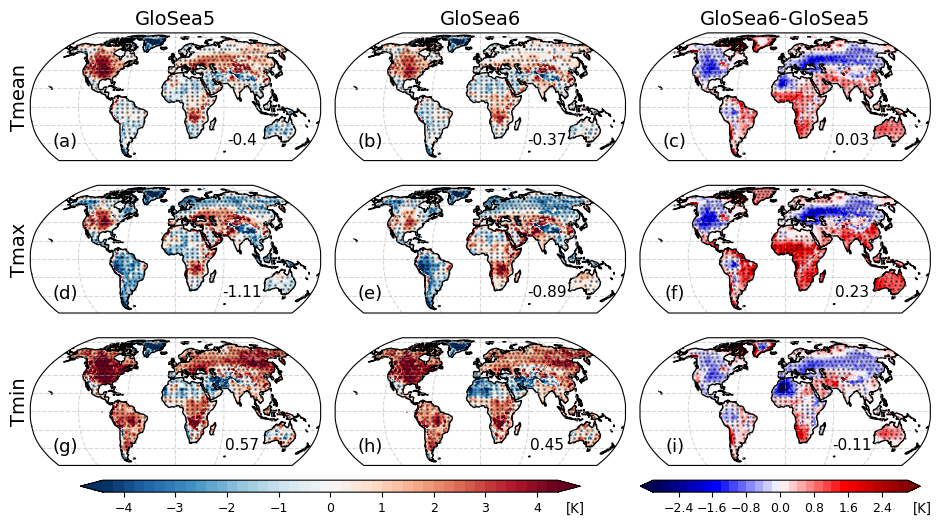

In [89]:
import string
from shapely.geometry.polygon import LinearRing, Polygon

alphabet = list(string.ascii_lowercase)

nrows = 3
ncols = 3
var_names = ['Tmean','Tmax','Tmin']
titles = ['GloSea5','GloSea6','GloSea6-GloSea5']
units = ['K','K']
fname='./fig/glosea_temp_bias.png'
clevs1=np.arange(-4.4,4.6,0.2)
clevs2=np.arange(-3.0,3.2,0.2)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(10,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = bias_map2[pp%ncols,pp//nrows,:,:]
    data2 = rmse_map2[pp%ncols,pp//nrows,:,:]
    data3 = bias_sig_map2[pp%ncols,pp//nrows,:,:]
    
    if pp==2 or pp==5 or pp==8:
        mask = bias_map[0,0,0,:,:]
        data  = data.where( ~np.isnan(mask) )
        data2 = data2.where( ~np.isnan(mask) )
        data3 = data3.where( ~np.isnan(mask) )
        clevs = clevs2
        cmap = 'seismic'
    else:
        clevs = clevs1
        cmap = 'RdBu_r'

    dint=8

    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmap,extend='both')
        
    if pp==2 or pp==5 or pp==8:
        cs2 = cs
    else:
        cs1 = cs
    
    # axs[pp].contourf(bias_map.lon,bias_map.lat, sig_map[pp,:,:].where(sig_map[pp,:,:]<=0.01), hatches=["."], alpha=0)
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    if pp//ncols == 0:
        axs[pp].set_title(titles[pp], fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    rmse = area_avg_weight(data2, 'lon', 'lat')
    bias = area_avg_weight(data, 'lon', 'lat')
    axs[pp].annotate('{}'.format(round(bias,2)),xy=(0.73, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=11)
    
    axs[pp].annotate('({})'.format(alphabet[pp]),xy=(0.12, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=13)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    
for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=14, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)




# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.1, 0.12, 0.5, 0.02])
cbar_ax1 = fig.add_axes([0.66, 0.12, 0.28, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal')
cbar.set_label('[{}]'.format(units[0]), fontsize=9.5, x=1.04, labelpad=-10)
cbar.ax.tick_params(labelsize=9)

cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
cbar1.set_label('[{}]'.format(units[1]), fontsize=9.5, x=1.06, labelpad=-10)
cbar1.ax.tick_params(labelsize=9)

# Add a big title at the top
plt.savefig(fname, dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

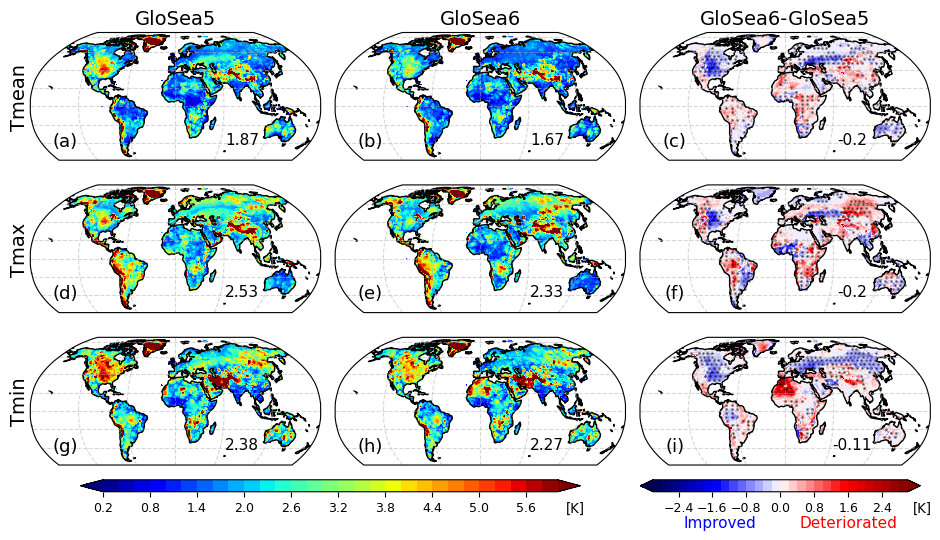

In [90]:
import string
from shapely.geometry.polygon import LinearRing, Polygon

alphabet = list(string.ascii_lowercase)

nrows = 3
ncols = 3
var_names = ['Tmean','Tmax','Tmin']
titles = ['GloSea5','GloSea6','GloSea6-GloSea5']
units = ['K','K']
fname='./fig/glosea_temp_rmse.png'
clevs1=np.arange(0.2,6.2,0.2)
clevs2=np.arange(-3.0,3.2,0.2)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(10,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = rmse_map2[pp%ncols,pp//nrows,:,:]
    # data2 = rmse_map2[pp%ncols,pp//nrows,:,:]
    data3 = rmse_sig_map2[pp%ncols,pp//nrows,:,:]
    
    if pp==2 or pp==5 or pp==8:
        mask = bias_map[0,0,0,:,:]
        data  = data.where( ~np.isnan(mask) )
        # data2 = data2.where( ~np.isnan(mask) )
        data3 = data3.where( ~np.isnan(mask) )
        clevs = clevs2
        cmap = 'seismic'
    else:
        clevs = clevs1
        cmap = 'jet'

    dint=8

    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmap,extend='both')
    
    if pp==2 or pp==5 or pp==8:
        cs2 = cs
    else:
        cs1 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4, transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    if pp//ncols == 0:
        axs[pp].set_title(titles[pp], fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
   
    bias = area_avg_weight(data, 'lon', 'lat')
    axs[pp].annotate('{}'.format(round(bias,2)),xy=(0.73, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=11)
    
    axs[pp].annotate('({})'.format(alphabet[pp]),xy=(0.12, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=13)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    

for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=14, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)


# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.1, 0.12, 0.5, 0.02])
cbar_ax1 = fig.add_axes([0.66, 0.12, 0.28, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal')
cbar.set_label('[{}]'.format(units[0]), fontsize=9.5, x=1.04, labelpad=-10)
cbar.ax.tick_params(labelsize=9)

cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
cbar1.set_label('[{}]'.format(units[1]), fontsize=9.5, x=1.06, labelpad=-10)
cbar1.ax.tick_params(labelsize=9)

axs[pp].text(0.4,-0.45, 'Improved', color='blue', size=11, rotation=0, verticalalignment="center", horizontalalignment='right', transform=axs[pp].transAxes)
axs[pp].text(0.55,-0.45, 'Deteriorated', color='red', size=11, rotation=0, verticalalignment="center", horizontalalignment='left', transform=axs[pp].transAxes)

plt.savefig(fname, dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

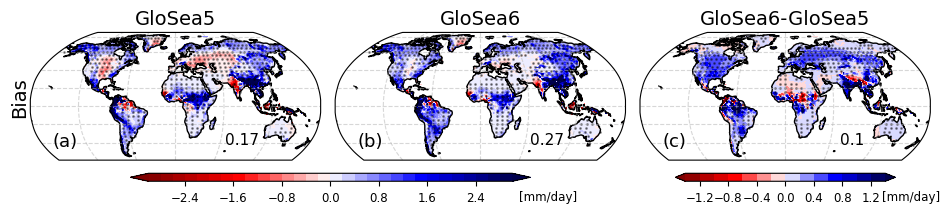

In [97]:
import string
from shapely.geometry.polygon import LinearRing, Polygon

alphabet = list(string.ascii_lowercase)

nrows = 1
ncols = 3
var_names = ['Bias']
titles = ['GloSea5','GloSea6','GloSea6-GloSea5']
units = ['mm/day','mm/day']
fname='./fig/glosea_pr_bias.png'
clevs1=np.arange(-3.0,3.2,0.2)
clevs2=np.arange(-1.4,1.6,0.2)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(10,2))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = bias_map3[pp%ncols,:,:]
    data2 = rmse_map3[pp%ncols,:,:]
    data3 = bias_sig_map3[pp%ncols,:,:]
    
    if pp==2 or pp==5 or pp==8:
        mask = bias_map[0,0,0,:,:]
        data  = data.where( ~np.isnan(mask) )
        data2 = data2.where( ~np.isnan(mask) )
        data3 = data3.where( ~np.isnan(mask) )
        clevs = clevs2
        cmap = 'seismic_r'
    else:
        mask = bias_map[0,0,0,:,:]
        data  = data.where( ~np.isnan(mask) )
        data2 = data2.where( ~np.isnan(mask) )
        data3 = data3.where( ~np.isnan(mask) )
        clevs = clevs1
        cmap = 'seismic_r'

    dint=8

    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmap,extend='both')
        
    if pp==2 or pp==5 or pp==8:
        cs2 = cs
    else:
        cs1 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4,transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    if pp//ncols == 0:
        axs[pp].set_title(titles[pp], fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
       
    rmse = area_avg_weight(data2, 'lon', 'lat')
    bias = area_avg_weight(data, 'lon', 'lat')
    # axs[pp].annotate('{}\n({})'.format(round(bias,2),round(rmse,2)),xy=(0.73, 0.32), xycoords='axes fraction',
    #             horizontalalignment='center', verticalalignment='top', color='black', fontsize=11)
    axs[pp].annotate('{}'.format(round(bias,2)),xy=(0.73, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=11)
    
    axs[pp].annotate('({})'.format(alphabet[pp]),xy=(0.12, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=13)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    
for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=14, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)




# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.15, 0.1, 0.4, 0.04])
cbar_ax1 = fig.add_axes([0.695, 0.1, 0.22, 0.04])

# Draw the colorbar
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal')
cbar.set_label('[{}]'.format(units[0]), fontsize=8.5, x=1.1, labelpad=-10)
cbar.ax.tick_params(labelsize=8.5)

cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
cbar1.set_label('[{}]'.format(units[1]), fontsize=8.5, x=1.13, labelpad=-10)
cbar1.ax.tick_params(labelsize=8.5)

plt.savefig(fname, dpi=500, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

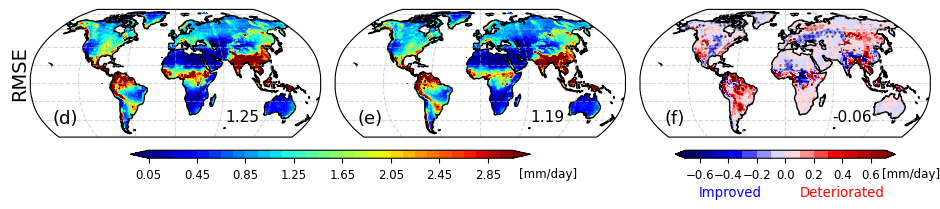

In [98]:
import string
from shapely.geometry.polygon import LinearRing, Polygon

alphabet = list(string.ascii_lowercase)

nrows = 1
ncols = 3
var_names = ['RMSE']
titles = ['','','']
units = ['mm/day','mm/day']
fname='./fig/glosea_pr_rmse.png'
clevs1=np.arange(0.05,3.15,0.1)
clevs2=np.arange(-0.7,0.8,0.1)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(10,2))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = rmse_map3[pp%ncols,:,:]
    # data2 = rmse_map3[pp%ncols,:,:]
    data3 = rmse_sig_map3[pp%ncols,:,:]
    
    if pp==2 or pp==5 or pp==8:
        mask = bias_map[0,0,0,:,:]
        data  = data.where( ~np.isnan(mask) )
        # data2 = data2.where( ~np.isnan(mask) )
        data3 = data3.where( ~np.isnan(mask) )
        clevs = clevs2
        cmap = 'seismic'
    else:
        mask = bias_map[0,0,0,:,:]
        data  = data.where( ~np.isnan(mask) )
        # data2 = data2.where( ~np.isnan(mask) )
        data3 = data3.where( ~np.isnan(mask) )
        clevs = clevs1
        cmap = 'jet'

    dint=8

    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmap,extend='both')
    
    if pp==2 or pp==5 or pp==8:
        cs2 = cs
    else:
        cs1 = cs
    
    # axs[pp].contourf(bias_map.lon,bias_map.lat, sig_map[pp,:,:].where(sig_map[pp,:,:]<=0.01), hatches=["."], alpha=0)
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=2, alpha=0.4, transform = ccrs.PlateCarree())
    
    # Title each subplot with the name of the model
    if pp//ncols == 0:
        axs[pp].set_title(titles[pp], fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # rmse = area_avg_weight(data2, 'lon', 'lat')
    bias = area_avg_weight(data, 'lon', 'lat')
    # axs[pp].annotate('{}\n({})'.format(round(bias,2),round(rmse,2)),xy=(0.73, 0.32), xycoords='axes fraction',
    axs[pp].annotate('{}'.format(round(bias,2)),xy=(0.73, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=11)
    
    axs[pp].annotate('({})'.format(alphabet[pp+3]),xy=(0.12, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=13)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    

for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=14, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)




# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.15, 0.1, 0.4, 0.04])
cbar_ax1 = fig.add_axes([0.695, 0.1, 0.22, 0.04])

# Draw the colorbar
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal')
cbar.set_label('[{}]'.format(units[0]), fontsize=8.5, x=1.1, labelpad=-10)
cbar.ax.tick_params(labelsize=8.5)

cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
cbar1.set_label('[{}]'.format(units[1]), fontsize=8.5, x=1.13, labelpad=-10)
cbar1.ax.tick_params(labelsize=8.5)

axs[pp].text(0.42,-0.43, 'Improved', color='blue', size=9.5, rotation=0, verticalalignment="center", horizontalalignment='right', transform=axs[pp].transAxes)
axs[pp].text(0.55,-0.43, 'Deteriorated', color='red', size=9.5, rotation=0, verticalalignment="center", horizontalalignment='left', transform=axs[pp].transAxes)

plt.savefig(fname, dpi=500, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

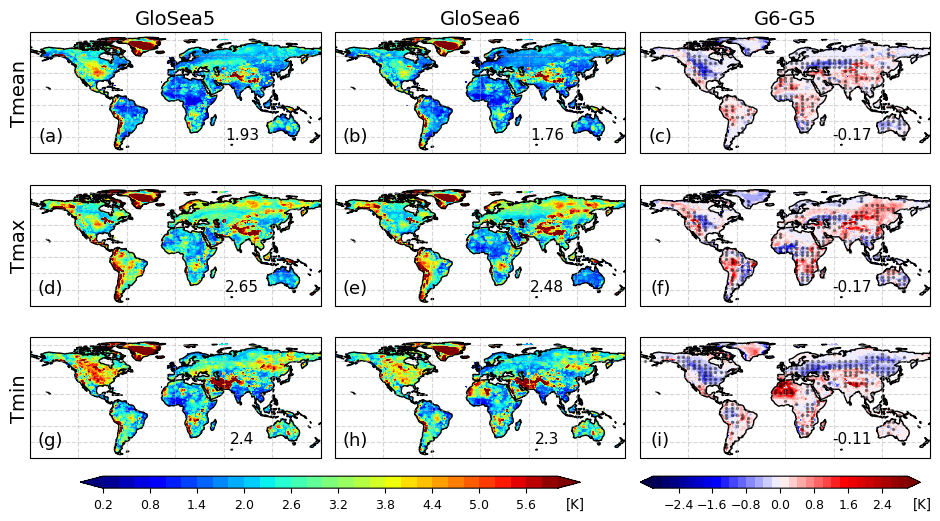

In [95]:
import string
from shapely.geometry.polygon import LinearRing, Polygon

alphabet = list(string.ascii_lowercase)

nrows = 3
ncols = 3
lead = 0
var_names = ['Tmean','Tmax','Tmin']
titles = ['GloSea5','GloSea6','G6-G5']
units = ['K','K']
fname='./fig/glosea_temp_rmse_US_lead'+str(lead)+'.png'
clevs1=np.arange(0.2,6.2,0.2)
clevs2=np.arange(-3.0,3.2,0.2)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    data = rmse_map[pp%ncols,pp//nrows,lead,:,:]
    # data2 = rmse_map[pp%ncols,pp//nrows,lead,:,:]
    data3 = rmse_sig_map[pp%ncols,pp//nrows,lead,:,:]
    
    if pp==2 or pp==5 or pp==8:
        mask = bias_map[0,0,0,:,:]
        data  = data.where( ~np.isnan(mask) )
        # data2 = data2.where( ~np.isnan(mask) )
        data3 = data3.where( ~np.isnan(mask) )
        clevs = clevs2
        cmap = 'seismic'
    else:
        clevs = clevs1
        cmap = 'jet'

    dint=8

    cs=axs[pp].contourf(data['lon'],data['lat'],data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmap,extend='both')
    
    if pp==2 or pp==5 or pp==8:
        cs2 = cs
    else:
        cs1 = cs
    
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<=0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<=0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=3, alpha=0.4)
    
    # Title each subplot with the name of the model
    if pp//ncols == 0:
        axs[pp].set_title(titles[pp], fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    
    # rmse = area_avg_weight(data2, 'lon', 'lat')
    bias = area_avg_weight(data, 'lon', 'lat')
    axs[pp].annotate('{}'.format(round(bias,2)),xy=(0.73, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=11)
    
    axs[pp].annotate('({})'.format(alphabet[pp]),xy=(0.07, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=13)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    
for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=14, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)




# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.1, 0.12, 0.5, 0.02])
cbar_ax1 = fig.add_axes([0.66, 0.12, 0.28, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal')
cbar.set_label('[{}]'.format(units[0]), fontsize=9.5, x=1.04, labelpad=-10)
cbar.ax.tick_params(labelsize=9)

cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
cbar1.set_label('[{}]'.format(units[1]), fontsize=9.5, x=1.06, labelpad=-10)
cbar1.ax.tick_params(labelsize=9)

plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()